<a href="https://colab.research.google.com/github/leighTOR/fishlens-vit/blob/main/vitv1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install timm
!pip install torch torchvision
!pip install roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.8
    Uninstalling idna-3.8:
      Successfully uninstalled idna-3.8


In [2]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
from timm import create_model
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, average_precision_score
import numpy as np
from roboflow import Roboflow
import seaborn as sns
import csv
import time
import pandas as pd

In [4]:
# Roboflow dataset loading
rf = Roboflow(api_key="W65oY4Om8xYEo0mK9UED")
project = rf.workspace("fishlens").project("fishlens-modelv1")
version = project.version(2)
dataset = version.download("yolov5")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to fishlens-modelv1-2 in yolov5pytorch:: 100%|██████████| 15012/15012 [00:02<00:00, 6064.86it/s]


In [5]:
# Define the dataset class (unchanged)
class YoloDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.image_files = os.listdir(image_dir)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_files[idx])
        label_path = os.path.join(self.label_dir, self.image_files[idx].replace(".jpg", ".txt"))

        image = Image.open(image_path).convert("RGB")

        with open(label_path, 'r') as f:
            label_data = f.readlines()

        labels = []
        for label in label_data:
            parts = label.strip().split()
            class_label = int(parts[0])
            bbox = list(map(float, parts[1:5]))
            labels.append([class_label] + bbox)

        labels = torch.tensor(labels)

        if self.transform:
            image = self.transform(image)

        return image, labels

    def collate_fn(self, batch):
        images, labels = zip(*batch)
        max_len = max(len(l) for l in labels)
        padded_labels = [torch.cat([l, torch.zeros(max_len - len(l), 5)], dim=0) for l in labels]
        return torch.stack(images), torch.stack(padded_labels)


In [7]:
# Define image transformations
img_size = 224
batch_size = 32

train_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [16]:
# Setup directories
train_image_dir = '/content/fishlens-modelv1-2/train/images'
train_label_dir = '/content/fishlens-modelv1-2/train/labels'
val_image_dir = '/content/fishlens-modelv1-2/valid/images'
val_label_dir = '/content/fishlens-modelv1-2/valid/labels'

# Create datasets and dataloaders
train_dataset = YoloDataset(train_image_dir, train_label_dir, transform=train_transforms)
val_dataset = YoloDataset(val_image_dir, val_label_dir, transform=val_transforms)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=train_dataset.collate_fn)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=val_dataset.collate_fn)

# Load and modify the ViT model
model = create_model('vit_base_patch16_224', pretrained=True, num_classes=11)  # num_classes = 11 for your dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
num_classes = 11

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
# Training loop (same as in your original code)
def train(model, device, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        class_labels = labels[:, 0, 0].long().to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, class_labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = outputs.max(1)
        total += class_labels.size(0)
        correct += predicted.eq(class_labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(class_labels.cpu().numpy())

    accuracy = 100. * correct / total
    return running_loss / len(train_loader), accuracy, all_preds, all_labels

def validate(model, device, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, targets = inputs.to(device), labels[:, 0, 0].long().to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())

    accuracy = 100. * correct / total
    return running_loss / len(val_loader), accuracy, all_preds, all_labels

In [11]:
# Function to calculate precision, recall, F1, and mAP
def calculate_metrics(all_labels, all_preds):
    # Convert lists to 2D numpy arrays
    all_labels = np.array(all_labels).reshape(-1, 1)
    all_preds = np.array(all_preds).reshape(-1, 1)

    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro') # Changed this line
    mAP = average_precision_score(all_labels, all_preds, average='macro')
    return precision, recall, f1, mAP

In [12]:
# Main training loop (updated to 5 epochs)
num_epochs = 5
save_dir = "/content/metrics"
os.makedirs(save_dir, exist_ok=True)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
precisions, recalls, f1s, mAPs = [], [], [], []

for epoch in range(num_epochs):
    start_time = time.time()

    train_loss, train_accuracy, train_preds, train_labels = train(model, device, train_loader, criterion, optimizer)
    val_loss, val_accuracy, val_preds, val_labels = validate(model, device, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    precision, recall, f1, mAP = calculate_metrics(val_labels, val_preds)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    mAPs.append(mAP)

    epoch_time = time.time() - start_time

    print(f'Epoch {epoch+1}/{num_epochs} | Time: {epoch_time:.2f}s')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
    print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, mAP: {mAP:.4f}')

Epoch 1/5 | Time: 255.66s
Train Loss: 1.8545, Train Accuracy: 33.03%
Val Loss: 1.7990, Val Accuracy: 32.84%
Precision: 0.2583, Recall: 0.3684, F1 Score: 0.2798, mAP: 0.0830


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 2/5 | Time: 248.37s
Train Loss: 1.7666, Train Accuracy: 35.47%
Val Loss: 1.7908, Val Accuracy: 36.44%
Precision: 0.2903, Recall: 0.4202, F1 Score: 0.3119, mAP: 0.0723


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 3/5 | Time: 249.36s
Train Loss: 1.7417, Train Accuracy: 36.27%
Val Loss: 1.7624, Val Accuracy: 34.53%
Precision: 0.3443, Recall: 0.3714, F1 Score: 0.3046, mAP: 0.0743


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 4/5 | Time: 248.47s
Train Loss: 1.7271, Train Accuracy: 36.08%
Val Loss: 1.8437, Val Accuracy: 36.23%
Precision: 0.3038, Recall: 0.3641, F1 Score: 0.2971, mAP: 0.0987
Epoch 5/5 | Time: 247.89s
Train Loss: 1.7924, Train Accuracy: 34.57%
Val Loss: 1.8622, Val Accuracy: 26.91%
Precision: 0.2578, Recall: 0.2988, F1 Score: 0.2530, mAP: 0.0754


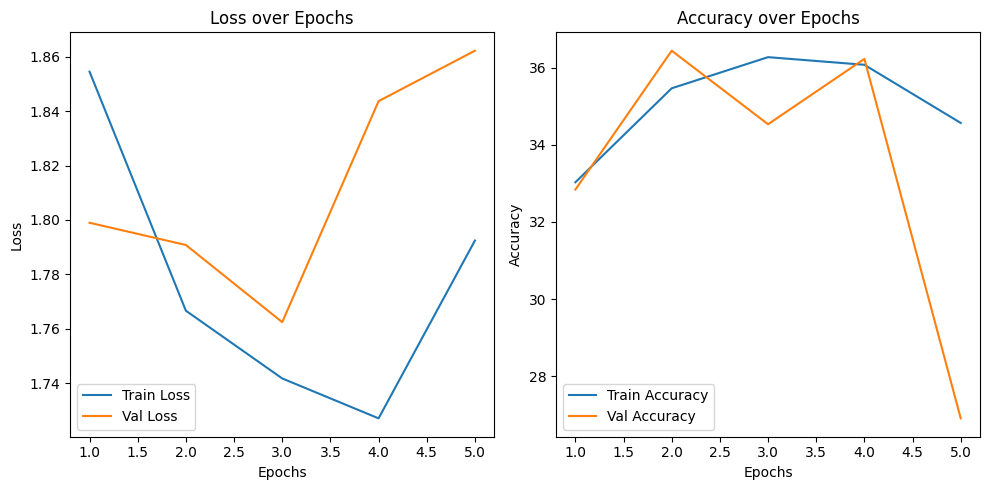

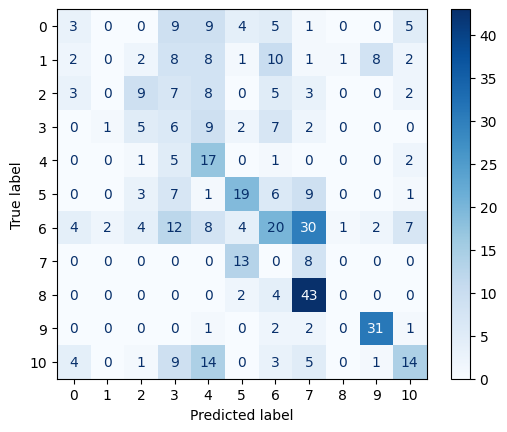

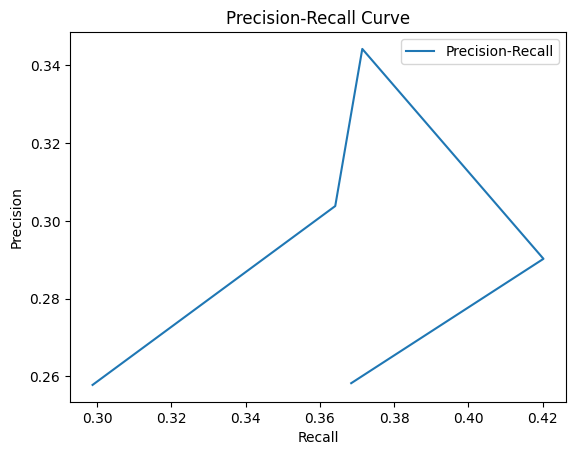

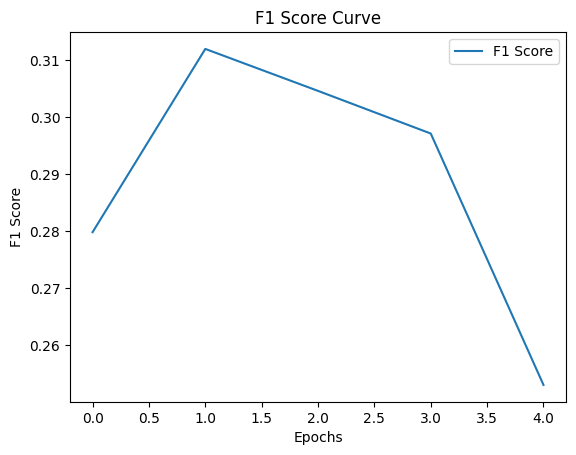

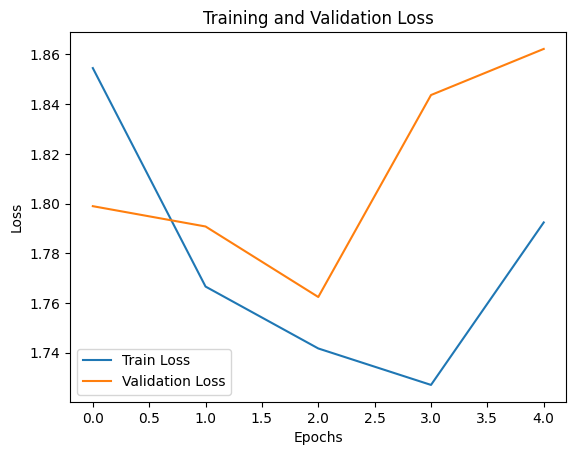

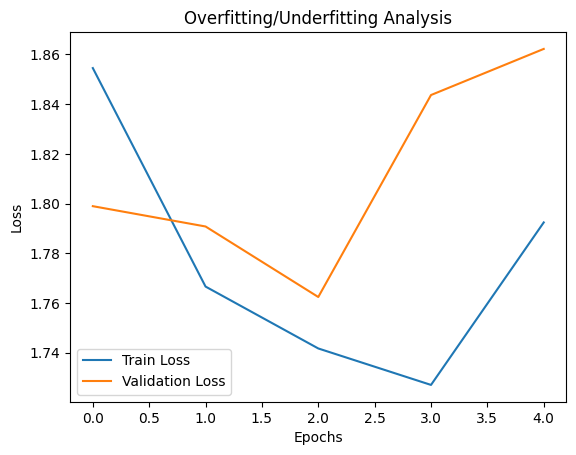

Metrics and plots are saved in /content/metrics


In [18]:

# Save results to CSV
with open(f'{save_dir}/metrics_results.csv', 'w', newline='') as csvfile:
    fieldnames = ['Epoch', 'Train Loss', 'Val Loss', 'Train Accuracy', 'Val Accuracy', 'Precision', 'Recall', 'F1 Score', 'mAP']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for i in range(num_epochs):
        writer.writerow({
            'Epoch': i + 1,
            'Train Loss': train_losses[i],
            'Val Loss': val_losses[i],
            'Train Accuracy': train_accuracies[i],
            'Val Accuracy': val_accuracies[i],
            'Precision': precisions[i],
            'Recall': recalls[i],
            'F1 Score': f1s[i],
            'mAP': mAPs[i]
        })

# Final graph plotting after the last epoch
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Val Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"{save_dir}/loss_accuracy_plot.png")
    plt.show()

# Display confusion matrix
def plot_confusion_matrix(val_labels, val_preds, num_classes):
    cm = confusion_matrix(val_labels, val_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(num_classes))
    disp.plot(cmap=plt.cm.Blues)
    plt.savefig(f"{save_dir}/confusion_matrix.png")
    plt.show()

# Additional graph plotting functions

# 1. Precision-Recall Curve
def plot_precision_recall_curve(recalls, precisions):
    plt.figure()
    plt.plot(recalls, precisions, label='Precision-Recall')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.savefig(f"{save_dir}/precision_recall_curve.png")
    plt.show()

# 2. F1-Score Curve
def plot_f1_score_curve(f1s):
    plt.figure()
    plt.plot(f1s, label='F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.title('F1 Score Curve')
    plt.legend()
    plt.savefig(f"{save_dir}/f1_score_curve.png")
    plt.show()

# 3. Loss Curves (Training and Validation)
def plot_loss_curves(train_losses, val_losses):
    plt.figure()
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.savefig(f"{save_dir}/loss_curves.png")
    plt.show()

# 4. Overfitting/Underfitting Analysis (Training vs Validation Loss)
def plot_overfitting_analysis(train_losses, val_losses):
    plt.figure()
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Overfitting/Underfitting Analysis')
    plt.legend()
    plt.savefig(f"{save_dir}/overfitting_analysis_loss.png")
    plt.show()

plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)
plot_confusion_matrix(val_labels, val_preds, num_classes)

# After training is complete, plot all the curves
plot_precision_recall_curve(recalls, precisions)  # Precision-Recall Curve
plot_f1_score_curve(f1s)  # F1-Score Curve
plot_loss_curves(train_losses, val_losses)  # Training and Validation Loss
plot_overfitting_analysis(train_losses, val_losses)  # Overfitting/Underfitting Analysis

# Also save the metrics to a text file (as you did before)
with open(f'{save_dir}/evaluation_metrics.txt', 'w') as f:
    f.write(f'Precision: {precisions[-1]}\n')
    f.write(f'Recall: {recalls[-1]}\n')
    f.write(f'F1 Score: {f1s[-1]}\n')
    f.write(f'mAP: {mAPs[-1]}\n')

print(f"Metrics and plots are saved in {save_dir}")

Index(['Epoch', 'Train Loss', 'Val Loss', 'Train Accuracy', 'Val Accuracy',
       'Precision', 'Recall', 'F1 Score', 'mAP'],
      dtype='object')


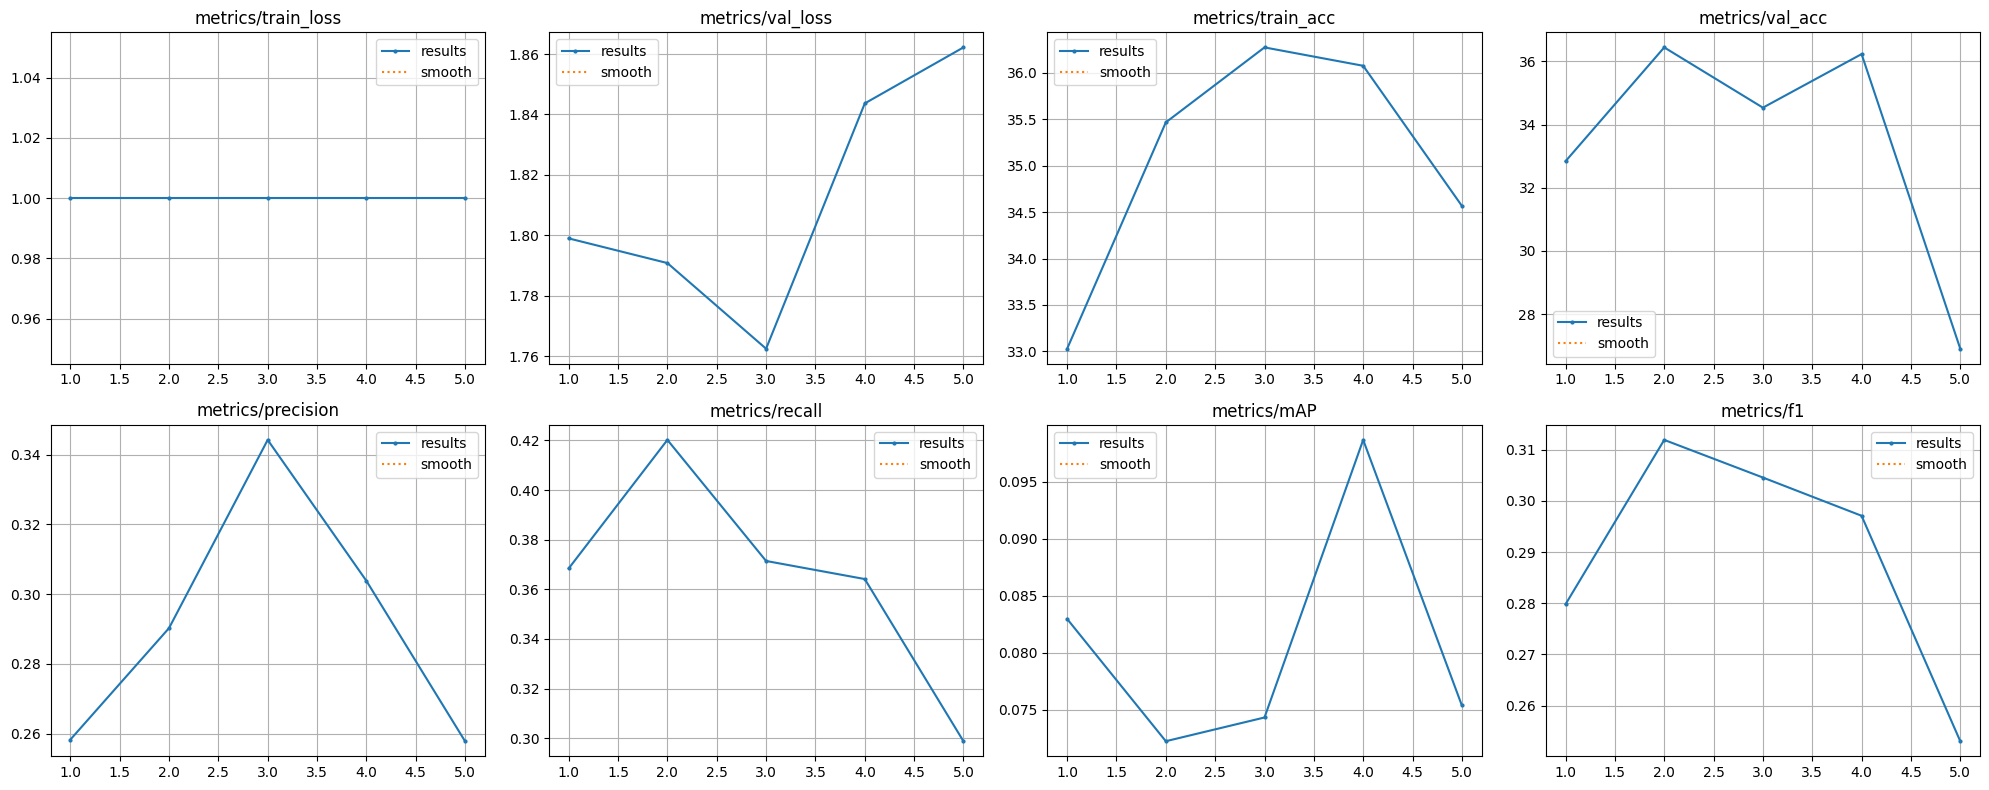

In [19]:

# Load the results.csv file
results_df = pd.read_csv('/content/metrics/metrics_results.csv')

# Strip any leading/trailing spaces in the column names
results_df.columns = results_df.columns.str.strip()

# Print the available columns to check for typos
print(results_df.columns)

# Assuming the correct column name is 'Train Loss' based on previous code
# Convert 'Train Loss' column to numeric, forcing errors to NaN
results_df['Train Loss'] = pd.to_numeric(results_df['Train Loss'], errors='coerce')

# Replace inf and NaN values with the median of the column
median_value = results_df['Train Loss'].median()
results_df['Train Loss'] = results_df['Train Loss'].replace([np.inf, -np.inf], np.nan)
results_df['Train Loss'].fillna(median_value, inplace=True)

# Now, you can safely clip the values if needed
results_df['Train Loss'] = results_df['Train Loss'].clip(upper=1.0)

# Define a smoothing function using a rolling window
def smooth(data, window_size=5):
    return data.rolling(window=window_size).mean()

# Extract columns and apply smoothing to relevant metrics
epochs = results_df['Epoch']
train_loss = results_df['Train Loss']
val_loss = results_df['Val Loss']
train_acc = results_df['Train Accuracy']
val_acc = results_df['Val Accuracy']
precision = results_df['Precision']
recall = results_df['Recall']
map = results_df['mAP']
f1= results_df['F1 Score']

# Apply smoothing to some metrics
smoothed_train_loss = smooth(train_loss)
smoothed_val_loss = smooth(val_loss)
smoothed_train_acc = smooth(train_acc)
smoothed_val_acc = smooth(val_acc)
smoothed_precision = smooth(precision)
smoothed_recall = smooth(recall)
smoothed_map = smooth(map)
smoothed_f1 = smooth(f1)

# Create the plot
fig, axs = plt.subplots(2, 4, figsize=(20, 8))

# First row: Training losses and precision/recall
axs[0, 0].plot(epochs, train_loss, label='results', marker='o', markersize=2)
axs[0, 0].plot(epochs, smoothed_train_loss, label='smooth', linestyle='dotted')
axs[0, 0].set_title('metrics/train_loss')

axs[0, 1].plot(epochs, val_loss, label='results', marker='o', markersize=2)
axs[0, 1].plot(epochs, smoothed_val_loss, label='smooth', linestyle='dotted')
axs[0, 1].set_title('metrics/val_loss')

axs[0, 2].plot(epochs, train_acc, label='results', marker='o', markersize=2)
axs[0, 2].plot(epochs, smoothed_train_acc, label='smooth', linestyle='dotted')
axs[0, 2].set_title('metrics/train_acc')

axs[0, 3].plot(epochs, val_acc, label='results', marker='o', markersize=2)
axs[0, 3].plot(epochs, smoothed_val_acc, label='smooth', linestyle='dotted')
axs[0, 3].set_title('metrics/val_acc')

# Second row: Validation losses and mAP metrics
axs[1, 0].plot(epochs, precision, label='results', marker='o', markersize=2)
axs[1, 0].plot(epochs, smoothed_precision, label='smooth', linestyle='dotted')
axs[1, 0].set_title('metrics/precision')

axs[1, 1].plot(epochs, recall, label='results', marker='o', markersize=2)
axs[1, 1].plot(epochs, smoothed_recall, label='smooth', linestyle='dotted')
axs[1, 1].set_title('metrics/recall')

axs[1, 2].plot(epochs, map, label='results', marker='o', markersize=2)
axs[1, 2].plot(epochs, smoothed_map, label='smooth', linestyle='dotted')
axs[1, 2].set_title('metrics/mAP')

axs[1, 3].plot(epochs, f1, label='results', marker='o', markersize=2)
axs[1, 3].plot(epochs, smoothed_f1, label='smooth', linestyle='dotted')
axs[1, 3].set_title('metrics/f1')

# Add legends and grid
for ax in axs.flat:
    ax.legend()
    ax.grid(True)

# Adjust layout to avoid overlap
plt.tight_layout()

# Save the plot as a PNG file
plt.savefig(f'{save_dir}/results_smoothed.png')

# Show the plot
plt.show()